# LDA Model Training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data

In [2]:
data_file_path='DATA.csv'
data=pd.read_csv(data_file_path)
data

,seq_no.,seq,module,motif_1,motif_2,motif_3,motif_4,motif_5,motif_string
0,0,GGAGGAGGAAGAGGCTGGGCCCCTGCTGTGTGGGGGCAAGTTCCCA...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3"
1,1,CAAATACCCTGGGGTGCAATACGACTTATATCTCACGTATTGGAAG...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4"
2,2,AACTAGGACACAGAAGTTGATCTAACGTAAACATCAAGAGCTTCCT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4"
3,3,CACAGCTGGGCCTGGTTGGTCTTTGTCCAGGGAACAATGGAGCGCC...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4"
4,4,TTGTTTTATTTGTTTGTTGGGGGGCGGCGGGGAGCGACAGGGGAGT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3"
...,...,...,...,...,...,...,...,...,...
995,995,CTATTATTAAGAAATATACACAATTTTAACTTCAAATATCTCTCAT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3"
996,996,ATTGATTCTCACTTGCTTGACTCAAGGGAGGGTTTGATTTTGGTCA...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4"
997,997,ATGTGGTTCTACCATATAGTTTATCAATTTTAAACAGGTAAAATAT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4"
998,998,ATTTTGTTGGTTAGGTGATGGAAGTATGATGCTATTGATATTTCCC...,2,0.0,1.0,0.0,0.0,1.0,"motif_2,motif_5"


In [3]:
print(data[data['motif_string'].isna()])
data.dropna(subset=['motif_string'],inplace=True)
data['motif_list']=data['motif_string'].apply(lambda x:x.split(','))
data

Empty DataFrame
Columns: [seq_no., seq, module, motif_1, motif_2, motif_3, motif_4, motif_5, motif_string]
Index: []


,seq_no.,seq,module,motif_1,motif_2,motif_3,motif_4,motif_5,motif_string,motif_list
0,0,GGAGGAGGAAGAGGCTGGGCCCCTGCTGTGTGGGGGCAAGTTCCCA...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
1,1,CAAATACCCTGGGGTGCAATACGACTTATATCTCACGTATTGGAAG...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
2,2,AACTAGGACACAGAAGTTGATCTAACGTAAACATCAAGAGCTTCCT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
3,3,CACAGCTGGGCCTGGTTGGTCTTTGTCCAGGGAACAATGGAGCGCC...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
4,4,TTGTTTTATTTGTTTGTTGGGGGGCGGCGGGGAGCGACAGGGGAGT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
...,...,...,...,...,...,...,...,...,...,...
995,995,CTATTATTAAGAAATATACACAATTTTAACTTCAAATATCTCTCAT...,0,0.0,1.0,1.0,0.0,0.0,"motif_2,motif_3","[motif_2, motif_3]"
996,996,ATTGATTCTCACTTGCTTGACTCAAGGGAGGGTTTGATTTTGGTCA...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
997,997,ATGTGGTTCTACCATATAGTTTATCAATTTTAAACAGGTAAAATAT...,1,1.0,0.0,0.0,1.0,0.0,"motif_1,motif_4","[motif_1, motif_4]"
998,998,ATTTTGTTGGTTAGGTGATGGAAGTATGATGCTATTGATATTTCCC...,2,0.0,1.0,0.0,0.0,1.0,"motif_2,motif_5","[motif_2, motif_5]"


In [4]:
from gensim.corpora import Dictionary

docs=data['motif_list'].values
dictionary=Dictionary(docs)

print('Motif-Index to Motif-Name Mapping:')
for i,v in dictionary.items():
    print(f'{i} - {v}')
    if i==10:
        break
    

Motif-Index to Motif-Name Mapping:
0 - motif_2
1 - motif_3
2 - motif_1
3 - motif_4
4 - motif_5


In [5]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('BOW (Sequence-0):')
docs[0],corpus[0]

BOW (Sequence-0):


(['motif_2', 'motif_3'], [(0, 1), (1, 1)])

## Training Test

In [6]:
%%time
import logging
from gensim.models.callbacks import Callback,PerplexityMetric, ConvergenceMetric, CoherenceMetric

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)
convergence_logger = ConvergenceMetric(logger='shell')
from gensim.models import LdaModel,LdaMulticore

temp = dictionary[0]
id2word = dictionary.id2token
lda = LdaModel(corpus, id2word=id2word, alpha='auto',chunksize=10000,
               eta='auto',num_topics=3, iterations=1000, passes = 5,
              minimum_probability=0.0,callbacks=[convergence_logger])

lda_predictions=lda.get_document_topics(corpus,minimum_probability=0.0)
lda_pred_topic=[]
for pred in tqdm(lda_predictions):
    top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
    lda_pred_topic.append(top_topic)
lda_pred_data=data.copy()
lda_pred_data['pred_topic']=lda_pred_topic

logging.getLogger().setLevel(logging.CRITICAL)

2021-02-24 13:30:59,628 : INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
2021-02-24 13:30:59,629 : INFO : using serial LDA version on this node
2021-02-24 13:30:59,630 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 1000x with a convergence threshold of 0.001000
2021-02-24 13:30:59,631 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-02-24 13:30:59,633 : DEBUG : bound: at document #0
2021-02-24 13:31:00,079 : INFO : -2.593 per-word bound, 6.0 perplexity estimate based on a held-out corpus of 1000 documents with 1931 words
2021-02-24 13:31:00,079 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-02-24 13:31:00,080 : DEBUG : performing inference on a chunk of 1000 documents
2021-02-24 13:31:00,431 : DEB

CPU times: user 2.26 s, sys: 203 ms, total: 2.46 s
Wall time: 2.28 s


## Model Evaluation Metrics

In [7]:
lda.get_topic_terms(0)

[(2, 0.6189055),
 (3, 0.37495264),
 (0, 0.0037638969),
 (1, 0.0018303924),
 (4, 0.0005475782)]

In [8]:
def getTopicDistribution(pred_data,ntopics):
    topic_dist_dict={i:0 for i in range(ntopics)}
    value_count=pred_data['pred_topic'].value_counts(normalize=True)
    for k,v in value_count.to_dict().items():
        topic_dist_dict[k]=v
    return topic_dist_dict

def likelihoodMetric(model,pred_data,dictionary,ntopics):
    likelihood=0
    P_T=getTopicDistribution(pred_data,ntopics)
    print(P_T)
    for idx,row in tqdm(pred_data.iterrows()):
        motif_list=dictionary.doc2idx(row['motif_list'])
        assigned_topic_no=row['pred_topic']
        P_Xi_M=0
        for topic_no in range(ntopics):
            ttd=model.get_topic_terms(topic_no)
            filtered_ttd=list(filter(lambda x:x[0] in motif_list,ttd))
            P_X_Ti=1
            for motif,P_mj_T in filtered_ttd:
                P_X_Ti*=P_mj_T
            P_Xi_M+=P_X_Ti*P_T[topic_no]
        likelihood+=np.log10(P_Xi_M)
    print(likelihood)
    return likelihood
likelihoodMetric(lda,lda_pred_data,dictionary,3)

622it [00:00, 3136.32it/s]

{0: 0.478, 1: 0.48, 2: 0.042}


1000it [00:00, 3177.92it/s]

-1059.6488458157767


-1059.6488458157767

In [9]:
# def getTopicDistribution(predictions,ntopics):
#     topic_count_dict={i:0 for i in range(ntopics)}
#     ndocs=len(predictions)
#     for pred in predictions:
#         top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
#         topic_count_dict[top_topic]+=1
#     topic_dist_dict={k:v/ndocs for k,v in topic_count_dict.items()}
#     print(topic_dist_dict)
#     return topic_dist_dict

# def likelihoodMetric(predictions,ntopics):
#     likelihood=0
#     P_T=getTopicDistribution(predictions,ntopics)
# #     print(P_T)
#     for pred in tqdm(predictions):
#         P_Xi_M=0
#         for topic_no,P_Xi_T in pred:
#             P_Xi_M+=P_Xi_T*P_T[topic_no]
#         likelihood+=np.log10(P_Xi_M)
#     print(likelihood)
#     return likelihood

In [10]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_cv(model,dictionary,docs):
    cm=CoherenceModel(model=model,dictionary=dictionary ,
                      texts=docs, coherence='c_v',processes=30,
                     window_size=2000)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
# coherenceMetric_cv(lda,dictionary ,docs)

In [11]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_umass(model,dictionary,corpus):
    cm = CoherenceModel(model=model, corpus=corpus, \
                        coherence='u_mass',processes=30)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
# coherenceMetric_umass(lda,dictionary ,corpus)

In [12]:
from gensim.models.coherencemodel import CoherenceModel

def coherenceMetric_uci(model,dictionary,docs):
    cm=CoherenceModel(model=model,dictionary=dictionary ,
                      texts=docs, coherence='c_uci',processes=30,
                     window_size =2000)
    coherence = cm.get_coherence()
    print(coherence)
    return coherence
coherenceMetric_uci(lda,dictionary ,docs)

-12.312024693235893


-12.312024693235893

In [13]:
def perplexityMetric(model,corpus):
    perplexity=model.log_perplexity(corpus)
    print(perplexity)
    return perplexity

In [14]:
from sklearn.metrics.cluster import adjusted_rand_score

def randIndexMetric(predictions,data):
    pred_topic=[]
    for pred in tqdm(predictions):
        topic_prob=sorted(pred,key=lambda x:-x[1])
#         print(topic_prob)
        top_topic=topic_prob[0][0]
        pred_topic.append(top_topic)
    _data=data.copy()
    _data['pred_topic']=pred_topic
    ari=adjusted_rand_score(_data['module'], _data['pred_topic'])
    print(ari)
    return ari

In [15]:
from collections import Counter

def findTopMotifs(pred_data,ntopics,ntop=5,outdir=None):     
    gb=pred_data[['motif_string','pred_topic']].groupby('pred_topic').\
    agg(lambda x: ','.join(x))
    gb['top_motif']=gb['motif_string'].\
    apply(lambda x:Counter(x.split(',')).most_common(ntop))
    gb.reset_index(inplace=True)
    gb=gb[['pred_topic','top_motif']]
    if outdir is not None:
        gb.to_csv(f'{outdir}/top{ntop}_motifs_topics_{ntopics}.csv',index=False)
    print(gb)
    return gb
# findTopMotifs(lda_pred_data,3)

## Training & Evaluation

In [16]:

from gensim.models import LdaModel,LdaMulticore

outdir='model_output'
eval_dict={'num_topics':[],'likelihood':[],'coherence_cv':[],\
          'coherence_umass':[],'coherence_uci':[],'perplexity':[]}
temp = dictionary[0]
id2word = dictionary.id2token
for ntopics in range(2,10):
    print('\n'+'='*40)
    print('Num of Topics = '+str(ntopics))
    model = LdaModel(corpus, id2word=id2word, alpha='auto',chunksize=10000,
                   eta='auto',num_topics=ntopics, iterations=1000, passes = 5,
                  minimum_probability=0.0)
    
    predictions=model.get_document_topics(corpus,minimum_probability=0.0)
    pred_topic=[]
    for pred in tqdm(predictions):
        top_topic=sorted(pred,key=lambda x:-x[1])[0][0]
        pred_topic.append(top_topic)
    pred_data=data.copy()
    pred_data['pred_topic']=pred_topic
    print('\nFinding likelihood...')
#     likelihood=likelihoodMetric(pred_data,predictions,ntopics)
    likelihood=likelihoodMetric(model,pred_data,dictionary,ntopics)
    print('\nFinding coherence_cv...')
    coherence_cv=coherenceMetric_cv(model,dictionary,docs)
    print('\nFinding coherence_umass...')
    coherence_umass=coherenceMetric_umass(model,dictionary ,corpus)
    print('\nFinding coherence_uci...')
    coherence_uci=coherenceMetric_uci(model,dictionary,docs)
    print('\nFinding perplexity...')
    perplexity=perplexityMetric(model,corpus)
    print('\nFinding Top Motifs...')
    findTopMotifs(pred_data,ntopics,outdir=outdir)
#     print('\nFindng avg. distance from TSS per topic...')
#     getAvgTssDist(pred_data,ntopics,outdir=outdir)
    eval_dict['num_topics'].append(ntopics)
    eval_dict['likelihood'].append(likelihood)
    eval_dict['coherence_cv'].append(coherence_cv)
    eval_dict['coherence_umass'].append(coherence_umass)
    eval_dict['coherence_uci'].append(coherence_uci)
    eval_dict['perplexity'].append(perplexity)
eval_df=pd.DataFrame(eval_dict)
eval_df.to_csv(f'{outdir}/metrics.csv',index=False)
eval_df


Num of Topics = 2


100%|██████████| 1000/1000 [00:00<00:00, 6826.10it/s]
365it [00:00, 3644.30it/s]


Finding likelihood...
{0: 0.52, 1: 0.48}


1000it [00:00, 3129.03it/s]

-1081.7886364118724

Finding coherence_cv...


0.22050510349084831

Finding coherence_umass...
-13.724379999203142

Finding coherence_uci...
-12.312024693235895

Finding perplexity...
-1.396633046292876

Finding Top Motifs...
   pred_topic                                          top_motif
0           0  [(motif_2, 520), (motif_3, 480), (motif_1, 86)...
1           1     [(motif_1, 478), (motif_4, 325), (motif_5, 2)]

Num of Topics = 3


100%|██████████| 1000/1000 [00:00<00:00, 5427.35it/s]
682it [00:00, 3391.08it/s]


Finding likelihood...
{0: 0.478, 1: 0.522, 2: 0}


1000it [00:00, 3373.29it/s]

-1068.3325802563206

Finding coherence_cv...


0.2205051034908483

Finding coherence_umass...
-13.906557615131524

Finding coherence_uci...
-12.312024693235893

Finding perplexity...
-1.4665321661578998

Finding Top Motifs...
   pred_topic                                          top_motif
0           0                   [(motif_1, 478), (motif_4, 325)]
1           1  [(motif_2, 520), (motif_3, 480), (motif_1, 86)...

Num of Topics = 4


100%|██████████| 1000/1000 [00:00<00:00, 3398.55it/s]
486it [00:00, 2419.57it/s]


Finding likelihood...
{0: 0.48, 1: 0.195, 2: 0.325, 3: 0}


1000it [00:00, 2424.50it/s]

-1168.120157469577

Finding coherence_cv...


0.2205051034908483

Finding coherence_umass...
-13.889621325543992

Finding coherence_uci...
-12.312024693235895

Finding perplexity...
-1.633577910592902

Finding Top Motifs...
   pred_topic                                        top_motif
0           0  [(motif_2, 480), (motif_3, 480), (motif_1, 86)]
1           1   [(motif_1, 153), (motif_5, 42), (motif_2, 40)]
2           2                 [(motif_1, 325), (motif_4, 325)]

Num of Topics = 5


100%|██████████| 1000/1000 [00:00<00:00, 4586.24it/s]
552it [00:00, 2676.44it/s]


Finding likelihood...
{0: 0, 1: 0.478, 2: 0.074, 3: 0.406, 4: 0.042}


1000it [00:00, 2559.59it/s]

-1064.7247840617276

Finding coherence_cv...


0.22050510349084834

Finding coherence_umass...
-13.799190528738105

Finding coherence_uci...
-12.312024693235895

Finding perplexity...
-1.619948157192758

Finding Top Motifs...
   pred_topic                                        top_motif
0           1                 [(motif_1, 478), (motif_4, 325)]
1           2    [(motif_1, 74), (motif_2, 74), (motif_3, 74)]
2           3  [(motif_2, 406), (motif_3, 406), (motif_1, 12)]
3           4                   [(motif_5, 42), (motif_2, 40)]

Num of Topics = 6


100%|██████████| 1000/1000 [00:00<00:00, 4337.88it/s]
241it [00:00, 2407.44it/s]


Finding likelihood...
{0: 0.086, 1: 0, 2: 0.436, 3: 0, 4: 0.438, 5: 0.04}


1000it [00:00, 1791.63it/s]

-1062.5569480590254

Finding coherence_cv...


0.22050510349084831

Finding coherence_umass...
-13.98128186149676

Finding coherence_uci...
-12.312024693235896

Finding perplexity...
-1.8017196841017067

Finding Top Motifs...
   pred_topic                                        top_motif
0           0    [(motif_1, 86), (motif_2, 86), (motif_3, 86)]
1           2  [(motif_2, 434), (motif_3, 394), (motif_5, 42)]
2           4                 [(motif_1, 438), (motif_4, 285)]
3           5                   [(motif_1, 40), (motif_4, 40)]

Num of Topics = 7


100%|██████████| 1000/1000 [00:00<00:00, 2793.48it/s]
320it [00:00, 1563.13it/s]


Finding likelihood...
{0: 0.132, 1: 0.001, 2: 0.042, 3: 0.346, 4: 0.007, 5: 0, 6: 0.472}


1000it [00:00, 1609.10it/s]

-1096.3353722094048

Finding coherence_cv...


0.2205051034908483

Finding coherence_umass...
-13.852793135717643

Finding coherence_uci...
-12.312024693235896

Finding perplexity...
-1.8877449549121106

Finding Top Motifs...
   pred_topic                                        top_motif
0           0                 [(motif_1, 132), (motif_4, 131)]
1           1       [(motif_1, 1), (motif_2, 1), (motif_3, 1)]
2           2                   [(motif_5, 42), (motif_2, 40)]
3           3                 [(motif_1, 346), (motif_4, 194)]
4           4       [(motif_2, 7), (motif_3, 7), (motif_1, 1)]
5           6  [(motif_2, 472), (motif_3, 472), (motif_1, 84)]

Num of Topics = 8


100%|██████████| 1000/1000 [00:00<00:00, 6263.81it/s]
425it [00:00, 2128.91it/s]


Finding likelihood...
{0: 0.042, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.48, 6: 0, 7: 0.478}


1000it [00:00, 2051.50it/s]

-1034.6766384514988

Finding coherence_cv...


0.22050510349084834

Finding coherence_umass...
-13.859140301167534

Finding coherence_uci...
-12.312024693235895

Finding perplexity...
-1.8336653828925724

Finding Top Motifs...
   pred_topic                                        top_motif
0           0                   [(motif_5, 42), (motif_2, 40)]
1           5  [(motif_2, 480), (motif_3, 480), (motif_1, 86)]
2           7                 [(motif_1, 478), (motif_4, 325)]

Num of Topics = 9


100%|██████████| 1000/1000 [00:00<00:00, 3393.95it/s]
149it [00:00, 1483.72it/s]


Finding likelihood...
{0: 0.24, 1: 0, 2: 0, 3: 0, 4: 0.238, 5: 0.074, 6: 0, 7: 0.406, 8: 0.042}


1000it [00:00, 1620.86it/s]

-1066.661195476034

Finding coherence_cv...


0.22050510349084831

Finding coherence_umass...
-13.822465014852243

Finding coherence_uci...
-12.312024693235895

Finding perplexity...
-1.9764882143584945

Finding Top Motifs...
   pred_topic                                        top_motif
0           0                 [(motif_1, 240), (motif_4, 240)]
1           4                  [(motif_1, 238), (motif_4, 85)]
2           5    [(motif_1, 74), (motif_2, 74), (motif_3, 74)]
3           7  [(motif_2, 406), (motif_3, 406), (motif_1, 12)]
4           8                   [(motif_5, 42), (motif_2, 40)]


,num_topics,likelihood,coherence_cv,coherence_umass,coherence_uci,perplexity
0,2,-1081.788636,0.220505,-13.724380,-12.312025,-1.396633
1,3,-1068.332580,0.220505,-13.906558,-12.312025,-1.466532
2,4,-1168.120157,0.220505,-13.889621,-12.312025,-1.633578
3,5,-1064.724784,0.220505,-13.799191,-12.312025,-1.619948
4,6,-1062.556948,0.220505,-13.981282,-12.312025,-1.801720
5,7,-1096.335372,0.220505,-13.852793,-12.312025,-1.887745
6,8,-1034.676638,0.220505,-13.859140,-12.312025,-1.833665
7,9,-1066.661195,0.220505,-13.822465,-12.312025,-1.976488


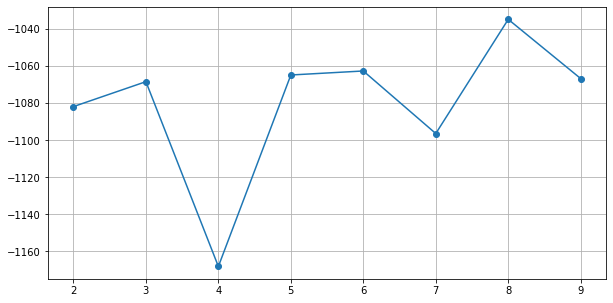

In [17]:
plt.figure(figsize=(10,5))
plt.plot(eval_df['num_topics'],eval_df['likelihood'],marker='o')
plt.grid()

In [18]:
# #setup logging for trainging metrics 
# import logging
# logging.basicConfig(filename='test_output/model_callbacks.log', filemode='w',
#                     format="%(asctime)s:%(levelname)s:%(message)s",
#                     level=logging.NOTSET)

# from gensim.models.callbacks import Callback,PerplexityMetric, ConvergenceMetric, CoherenceMetric
# perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
# convergence_logger = ConvergenceMetric(logger='shell')
# # coherence_cv_logger = CoherenceMetric(corpus=corpus, coherence = 'c_v', texts = docs)

# %%time
# from gensim.models import LdaModel,LdaMulticore

# #HYPERPARAMETERS
# #passes = epochs
# temp = dictionary[0]
# id2word = dictionary.id2token
# lda = LdaModel(corpus, id2word=id2word, alpha='auto',eval_every = 1,\
#                eta='auto',num_topics=3, iterations=5, passes = 10,
#               callbacks=[perplexity_logger,convergence_logger])

# lda.print_topics()

# %%time
# from gensim.models import LdaModel,LdaMulticore

# id2word = dictionary.id2token
# lda = LdaMulticore(corpus, id2word=id2word,eval_every = 1,\
#                eta='auto',num_topics=3, iterations=500, passes = 100)

# import pyLDAvis.gensim

# pyLDAvis.enable_notebook()
# pyLDAvis.gensim.prepare(lda, corpus, dictionary)